In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.25937492/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# Column density ratios

In [14]:
logN_dict = {'HI':'12.9, -0.1, +0.1',
            'HeI':'<13.3',
            'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            'NII':'<13.3',
            'NIII':'<13.2',
            'NIV':'<13.4',
            'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            'OVI':'<13.7',
            'NeV':'<13.4',
            'NeVI':'<15.3',
            'NeVIII':'<13.9',
            'MgX':'<13.8',
            'AlII':'<10.9',
            'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.5',
            'SVI':'<13.4',
            'FeII':'<11.5',}

In [15]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

'-0.22, -0.30, 0.20'

In [16]:
logN_ratio_dict = {'CIV/CIII': '-0.24, -0.20, 0.20'}

(-2.2, 2.5)

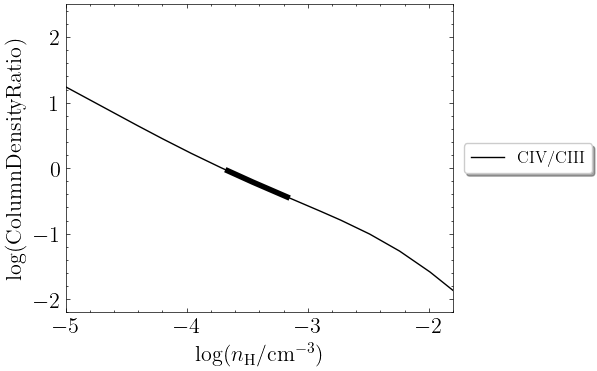

In [17]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

# Single phase solution

In [18]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [19]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [20]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [21]:
logN_dict = {#'HI':'12.9, -0.1, +0.1',
            'HeI':'<13.3',
            'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            'NII':'<13.3',
            'NIII':'<13.2',
            'NIV':'<13.4',
            'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            #'OVI':'<13.7',
            #'NeV':'<13.4',
            #'NeVI':'<15.3',
            #'NeVIII':'<13.9',
            #'MgX':'<13.8',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.5',
            'SVI':'<13.4',}
            #'FeII':'<11.5',}

In [22]:
logN_HI_test = 12.9
log_hdens_test = -3.3
log_metals_test = 0.6
C_O_test = 0.0
N_O_test = -2.0

In [23]:
#species_logN_interp['Si+2']([logN_HI_test, log_hdens_test_p1, log_metals_test_p1])[0]

In [24]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

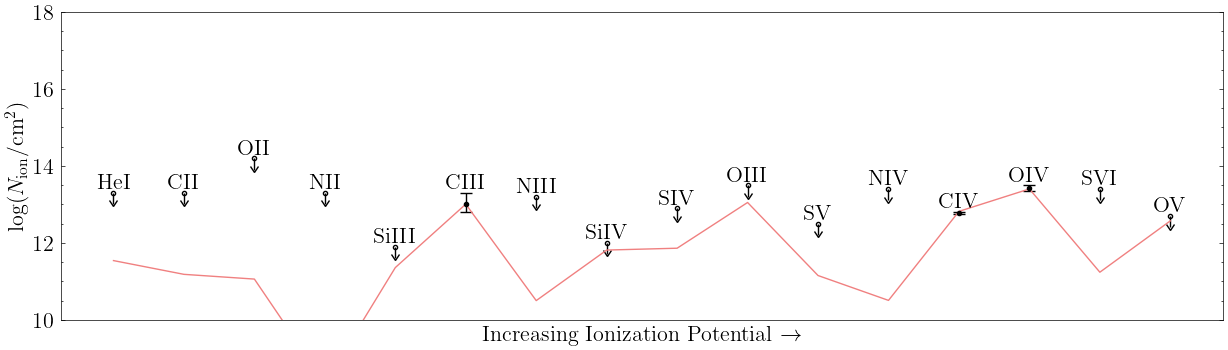

In [25]:
fig, ax = plot_column_densities_obs(logN_dict)
#ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
#ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [26]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [27]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [28]:
#sampler.run_mcmc(pos, 500, progress=True);

In [29]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'one_phase_c1.csv', index=False)

flat_samples = pd.read_csv(savedir+'one_phase_c1.csv')

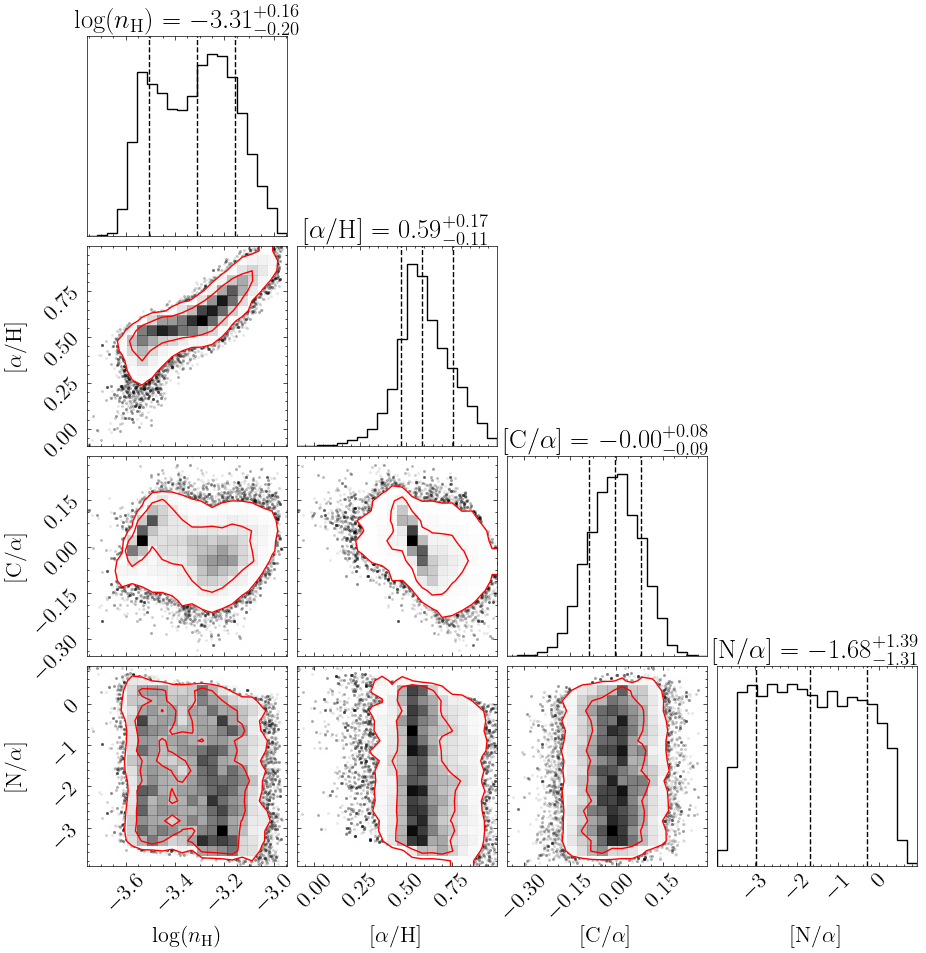

In [35]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{\alpha/H}]$', r'$[\mathrm{C/\alpha}]$', r'$[\mathrm{N/\alpha}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [32]:
np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)-np.median(flat_samples['log_hdens'])

0.15567695247122426

In [33]:
np.median(flat_samples['log_hdens'])-np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))

0.19774013474672802

In [34]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

0.6415023122244441

Now plot the best models

In [34]:
logN_dict = {#'HI':'12.9, -0.1, +0.1',
            #'HeI':'<13.3',
            #'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            #'NII':'<13.3',
            #'NIII':'<13.2',
            'NIV':'<13.4',
            #'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            #'OVI':'<13.7',
            #'NeV':'<13.4',
            #'NeVI':'<15.3',
            #'NeVIII':'<13.9',
            #'MgX':'<13.8',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',}
            #'SIV':'<12.9',
            #'SV':'<12.5',
            #'SVI':'<13.4',}
            #'FeII':'<11.5',}

In [35]:
b_dict = {'HI':'20, -2, +2',
          'CIII':'6.0, -0.7, +0.7',
          'CIV':'6.0, -0.7, +0.7',
          'OIV':'6.0, -0.7, +0.7'}

In [36]:
z_sys = 1.25937492

In [37]:
import matplotlib.lines as mlines

In [38]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [39]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [40]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

logN_res_up['SiIII'] = '<0.4'
logN_res_up['OIII'] = '<0.4'
logN_res_up['NIV'] = '<0.4'

In [41]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [42]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

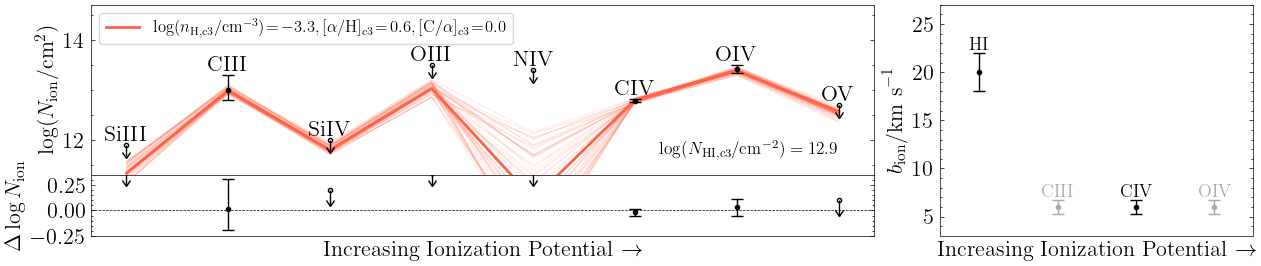

In [43]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI',
                                     'NeV', 'NeVI'], dy=.15)

axd['upper left'].set_ylim(11.3,14.7)

#axd['upper left'].text(len(logN_dict)-1, 13.7, r'PIE', fontsize=14,horizontalalignment='right')
axd['upper left'].text(len(logN_dict)-1, 11.7, r'$\log(N_\mathrm{HI, c3}/\mathrm{cm}^{-2}) = 12.9$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) \!=\! -3.3, \mathrm{[\alpha/H]_{c3}} \!=\! 0.6, \mathrm{[C/\alpha]_{c3}}\!=\!0.0$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-.25,.35)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [44]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

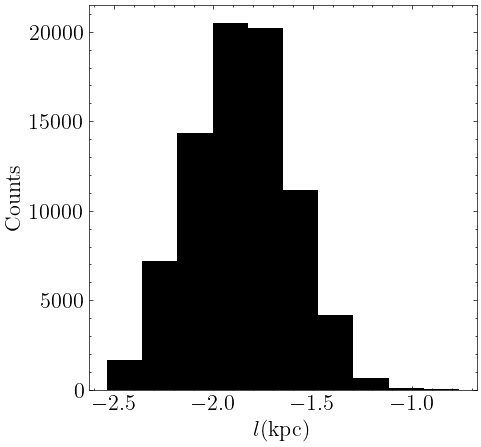

In [45]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$l (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [46]:
get_quantiles(np.log10(l))

-1.86 -0.27 0.25


In [47]:
np.median(np.log10(l))

-1.8578193543357608

In [48]:
np.percentile(np.log10(l), 100*cdf_1sig)-np.median(np.log10(l))

0.25250261129666396